<div style="background: linear-gradient(135deg, #28a745 0%, #212529 100%); padding: 30px; border-radius: 15px; margin: 20px 0; text-align: center; color: white; box-shadow: 0 8px 32px rgba(0,0,0,0.1);">
    <h1 style="font-size: 2.8em; margin: 0 0 15px 0; font-weight: 700; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">Notebook 3: Interactive Visual Analytics</h1>
    <h2 style="font-size: 1.6em; margin: 0; font-weight: 400; opacity: 0.9;">Visualizing Launch Sites, Maps, and Dashboards</h2>
</div>

<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="400" alt="Skills Network Logo">
    </a>
</p>

# **Hands-on Lab: Interactive Visual Analytics with Folium**
The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.<br>
<b>In the previous exploratory data analysis labs, you have visualized the SpaceX launch dataset using `matplotlib` and `seaborn` and discovered some preliminary correlations between the launch site and success rates. In this lab, you will be performing more interactive visual analytics using `Folium`.<b>


## Objectives

This lab contains the following tasks:

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon
import os
import requests
from io import BytesIO

# Dash imports
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

# Setting plotting style
sns.set_theme(style="whitegrid")

In [13]:
URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
response = requests.get(URL)
response.raise_for_status()
if response.status_code == 200:
    print("Successfully downloaded the file.")
else:
    print("Failed to download the file.")

df = pd.read_csv(BytesIO(response.content))
df.info()

Successfully downloaded the file.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
 17  Cla

In [ ]:
USA_latitude = 37.0902
USA_longitude = -95.7129

USA_map = folium.Map(location=[USA_latitude,USA_longitude],zoom_start=4,title='USA Map',tiles='Cartodb positron')
launch_lats = df['Latitude'].unique().tolist()
launch_lons = df['Longitude'].unique().tolist()
launch_sites = df['LaunchSite'].unique().tolist()
for lat,lon,launch_site in zip(launch_lats,launch_lons,launch_sites):
    folium.Marker(location=[lat,lon],popup=folium.Popup(f'Launch Site {launch_site} Location: ({str(lat)},{str(lon)})'),tooltip=folium.Tooltip(str(lat)+','+str(lon)),icon=folium.Icon(color='green',icon_color='white',icon='globe',prefix='fa')).add_to(USA_map)

formatter = 'function(num) {return L.Util.formatNum(num,5);};'
mouse_position = MousePosition(position='topright',separator=' Longitude: ',empty_string='Waiting...',lng_first=True,num_digits=20,prefix='Latitude: ',lat_formatter=formatter,lng_formatter=formatter)
USA_map.add_child(mouse_position)
USA_map

The following dataset with the name `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site.


In [ ]:
# Download and read the `spacex_launch_geo.csv`
import pandas as pd
import requests
from io import BytesIO

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
response = requests.get(URL)
response.raise_for_status()
if response.status_code == 200:
    print("Successfully downloaded the file.")
else:
    print("Failed to download the file.")
spacex_df = pd.read_csv(BytesIO(response.content))
spacex_df.head()


Successfully downloaded the file.


,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


In [15]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [16]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).last()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.

We could use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example,


In [ ]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True, fill_color='#d35400')

# Create a `folium.Marker` on the location of a launch site
marker = folium.Marker(nasa_coordinate, popup='NASA Johnson Space Center', icon=folium.Icon(color='green', icon_color='white', icon='globe', prefix='fa'))

# Add the circle and marker to the map
site_map.add_child(circle)
site_map.add_child(marker)

site_map

In [23]:
launch_sites_df2 = launch_sites_df.copy()
nasa_coordinate = [29.559684888503615, -95.0830971930759]
launch_sites_df2 = pd.concat([launch_sites_df,pd.DataFrame([nasa_coordinate],columns=['Lat','Long'])],axis=0)
launch_sites_df2.head()

site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

for lat, long, label in zip(launch_sites_df2['Lat'], launch_sites_df2['Long'], launch_sites_df2['Launch Site']):
    folium.CircleMarker(location=[lat, long], radius=5, color='green', fill=True, fill_color='green', fill_opacity=0.6, popup=label).add_to(site_map)
    folium.Marker(location=[lat, long], popup=label, icon=folium.Icon(color='blue', icon_color='white', icon='globe', prefix='fa')).add_to(site_map)
site_map



In [25]:
success = spacex_df.groupby('Launch Site',as_index=False)['class'].value_counts()
record = []
success_numbers = {}

for i, (site, cls, num) in enumerate(zip(success['Launch Site'], success['class'], success['count'])):
    if cls == 1:  # success class
        record.append(f'{site} failed {num} times')
        success_numbers[site] = num
    else:  # failure class
        record.append(f'{site} successd {num} times')

# To extract numbers from success records
for item in record:
    if 'success' in item:
        # Extract the number using regex
        match = re.search(r'success (\d+) times', item)
        if match:
            number = int(match.group(1))
            print(f"Success number: {number}")

record

['CCAFS LC-40 successd 19 times',
 'CCAFS LC-40 failed 7 times',
 'CCAFS SLC-40 successd 4 times',
 'CCAFS SLC-40 failed 3 times',
 'KSC LC-39A failed 10 times',
 'KSC LC-39A successd 3 times',
 'VAFB SLC-4E successd 6 times',
 'VAFB SLC-4E failed 4 times']

Now, you can explore the map by zoom-in/out the marked areas
, and try to answer the following questions:

*   Are all launch sites in proximity to the Equator line? No 
*   Are all launch sites in very close proximity to the coast? Yes

Also please try to explain your findings.


In [30]:
# Task 2: Mark the success/failed launches for each site on the map
# nasa_coordinate = [29.559684888503615, -95.0830971930759]
# launch_lats = df['Latitude'].unique().tolist()
# launch_lons = df['Longitude'].unique().tolist()
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first() # the first is the first row of each group
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df2 = launch_sites_df.copy()
nasa_coordinate = {'Launch Site':'NASA_coordinate','Lat':29.559684888503615,'Long':-95.0830971930759}
launch_sites_df2 = pd.concat([launch_sites_df,pd.DataFrame([nasa_coordinate])],axis=0)
launch_sites_df2.index = range(len(launch_sites_df2))
success = spacex_df.groupby('Launch Site',as_index=False)['class'].value_counts()
record = []

for i, (site, cls, num) in enumerate(zip(success['Launch Site'], success['class'], success['count'])):
    if cls == 1:  # success class
        record.append(f'{site} failed {num} times')
    else:  # failure class
        record.append(f'{site} successed {num} times')


USA_map = folium.Map(location=[37.0902,-95.7129],zoom_start=4,tiles='cartodb positron')

# Add equator line (latitude 0)
equator_line = folium.PolyLine(
    locations=[[0, -3600], [0, 360]],  # From longitude -180 to 180 at latitude 0
    color='red',
    weight=2,
    opacity=0.8,
    popup='Equator Line (0° Latitude)'
).add_to(USA_map)

for i,lat,lon,name in zip(range(1,len(launch_sites_df2)+1),launch_sites_df2['Lat'],launch_sites_df2['Long'],launch_sites_df2['Launch Site']):
    match = re.search(rf'({re.escape(name)})',str(record))
    if match:
        record_i = record[i-1:i+1]
        num_succeed = re.search(r'\s(\d+)\s',str(record_i[0]))
        num_failed = re.search(r'\s(\d+)\s',str(record_i[1]))
        launch_info = f'{name} succeed {num_succeed.group(1)} times, failed ({num_failed.group(1)} times)'
        folium.Marker(location=[lat,lon],tooltip=name,popup=launch_info,icon=folium.Icon(color='red',icon_color='white',icon='globe',prefix='fa')).add_to(USA_map)
        folium.CircleMarker(location=[lat,lon],radius=10,color='red',fill=True,fill_color='red',fill_opacity=0.6).add_to(USA_map)
    else:
        print(name)
        folium.Marker(location=[lat,lon],tooltip=name,popup=f'SPACE Launch Center{name}',icon=folium.Icon(color='green',icon_color='white',icon='globe',prefix='fa')).add_to(USA_map)
        # or 
        # folium.Marker(location=[lat,lon],popup=name,icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0),html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % name)).add_to(USA_map)
        folium.CircleMarker(location=[lat,lon],radius=10,color='green',fill=True,fill_color='green',fill_opacity=0.6).add_to(USA_map)
USA_map


NASA_coordinate


Next, let's create markers for all launch records.
If a launch was successful `(class=1)`, then we use a green marker and if a launch was failed, we use a red marker `(class=0)`

Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.


In [33]:
spacex_df

,Launch Site,Lat,Long,class,marker_color
0,CCAFS LC-40,28.562302,-80.577356,0,red
1,CCAFS LC-40,28.562302,-80.577356,0,red
2,CCAFS LC-40,28.562302,-80.577356,0,red
3,CCAFS LC-40,28.562302,-80.577356,0,red
4,CCAFS LC-40,28.562302,-80.577356,0,red
5,CCAFS LC-40,28.562302,-80.577356,0,red
6,CCAFS LC-40,28.562302,-80.577356,0,red
7,CCAFS LC-40,28.562302,-80.577356,0,red
8,CCAFS LC-40,28.562302,-80.577356,0,red
9,CCAFS LC-40,28.562302,-80.577356,0,red


In [98]:
marker_cluster = MarkerCluster()
spacex_df['marker_color'] = spacex_df['class'].apply(lambda x: 'green' if x == 1 else 'red')
# for lat,long,name,marker_color in zip(spacex_df['Lat'],spacex_df['Long'],spacex_df['Launch Site'],spacex_df['marker_color']):
for i, items in spacex_df.iterrows():
    lat = items['Lat']
    long = items['Long']
    name = items['Launch Site']
    marker_color = items['marker_color']
    marker_cluster.add_child(folium.Marker(location=[lat,long],tooltip=name,popup=name,icon=folium.Icon(color=marker_color,icon_color='white',icon='globe',prefix='fa')))
    circle = folium.CircleMarker(location=[lat,long],radius=10,color=marker_color,fill=True,fill_color=marker_color,fill_opacity=0.6)
    marker_cluster.add_child(circle)

USA_map = folium.Map(location=[37.0902,-95.7129],zoom_start=4,tiles='cartodb positron')
USA_map.add_child(marker_cluster)
USA_map


## TASK 3: Calculate the distances between a launch site to its proximities

- Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [71]:
launch_site_locations

[(np.float64(34.63283416), np.float64(-120.6107455)),
 (np.float64(28.56230197), np.float64(-80.57735648))]

In [89]:
spacex_df.loc[spacex_df['Launch Site']=='VAFB SLC-4E',:].value_counts().index[0][1:3]

(np.float64(34.63283416), np.float64(-120.6107455))

In [99]:
def calculate_distance(lat1,lon1,lat2,lon2):
    R=6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    distance_lon = lon2 - lon1
    distance_lat = lat2 - lat1
    a = sin(distance_lat/2)**2 + cos(lat1) * cos(lat2) * sin(distance_lon/2)**2
    c = 2 * atan2(sqrt(a),sqrt(1-a))
    distance = R * c
    return distance

coastline_location = [34.636081, -120.625919]
coastline_location2 = [28.563197,-80.576820]
coastline_locations = [coastline_location,coastline_location2]
launch_site_locations = [spacex_df.loc[spacex_df['Launch Site']=='VAFB SLC-4E',:].value_counts().index[0][1:3],spacex_df.loc[spacex_df['Launch Site']=='CCAFS LC-40',:].value_counts().index[0][1:3]]
launch_coastline_locations = {launch_site_locations[0]:coastline_locations[0],launch_site_locations[1]:coastline_locations[1]}

distance1 = calculate_distance(launch_site_locations[0][0],launch_site_locations[0][1],coastline_location[0],coastline_location[1])
distance2 = calculate_distance(launch_site_locations[1][0],launch_site_locations[1][1],coastline_location[0],coastline_location[1])
distance_list = [distance1,distance2]


# USA_map = folium.Map(location=[37.0902,-95.7129],zoom_start=4,tiles='cartodb positron')
children_to_remove = []
for child_name, child in USA_map._children.items():
    if hasattr(child, '_name') and 'mouseposition' in child._name.lower():
        children_to_remove.append(child_name)

for child_name in children_to_remove:
    USA_map._children.pop(child_name)

formatter = 'function(num) {return L.Util.formatNum(num,5);};'
mouse_position = MousePosition(position='topright',separator=' Longitude: ',empty_string='Waiting...',lng_first=True,num_digits=20,prefix='Latitude: ',lat_formatter=formatter,lng_formatter=formatter)
USA_map.add_child(mouse_position)
for distance,location in zip(distance_list,launch_coastline_locations.items()):
    coastline_distance_marker = folium.Marker(
    location=location[1],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
        )
    )
    USA_map.add_child(coastline_distance_marker)
    line = folium.PolyLine(locations=[location[0],location[1]],weight=1,color='green',opacity=0.5)
    USA_map.add_child(line)
# distance_marker = folium.Marker
USA_map


In [81]:
for location in launch_coastline_locations.items():
    print(location[1])


[34.636081, -120.625919]
[28.563197, -80.57682]


*TODO:* Similarly, you can draw a line betwee a launch site to its closest city, railway, highway, etc. You need to use `MousePosition` to find the their coordinates on the map first


## Hands-on Lab: Build an Interactive Dashboard with Plotly Dash

1. TASK 1: Add a Launch Site Drop-down Input Component
2. TASK 2: Add a callback function to render success-pie-chart based on selected site dropdown
3. TASK 3: Add a Range Slider to Select Payload
4. TASK 4: Add a callback function to render the success-payload-scatter-chart scatter plot






In [103]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import numpy as np
import math
from itertools import combinations

app = dash.Dash(__name__)
app.config.suppress_callback_exceptions = True


URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv"
response = requests.get(URL)
response.raise_for_status()
if response.status_code == 200:
    print("Successfully downloaded the file.")
else:
    print("Failed to download the file.")

data = pd.read_csv(BytesIO(response.content))
data.rename(columns={'class':'Class'},inplace=True)
payload_max = data['Payload Mass (kg)'].max()
payload_min = data['Payload Mass (kg)'].min()
payload_range = [int(payload_min),int(payload_max if payload_max % 1000 == 0 else ((payload_max + 1000)-payload_max%1000))]

maxium_success_rate_payload_range = {}
all_possible_choices_range = np.linspace(payload_range[0],payload_range[1],11,dtype=int)

# Verify we have the correct number of combinations
expected_combinations = math.comb(11, 2)
print(f"Expected number of combinations: {expected_combinations}")

# Generate all possible combinations of 2 choices from the 11 points
all_possible_choices = list(combinations(all_possible_choices_range, 2))

# Convert to list of lists and ensure we have exactly 55 combinations
all_possible_choices = [list(choice) for choice in all_possible_choices]
all_possible_choices.sort()
print(f"Actual number of combinations generated: {len(all_possible_choices)}")

# Calculate success rate for each payload range combination
for choice in all_possible_choices:
    choice_sorted = sorted(choice)  # Ensure consistent ordering
    filtered_df_payload = data[(data['Payload Mass (kg)'] >= choice_sorted[0]) & (data['Payload Mass (kg)'] <= choice_sorted[1])]
    if len(filtered_df_payload) > 0:  # Check if filtered_df is not empty
        success_rate_count = round(filtered_df_payload['Class'].sum() / len(filtered_df_payload), 4) * 100
        maxium_success_rate_payload_range[tuple(choice_sorted)] = success_rate_count  # Use tuple as key

print(f"Total payload ranges analyzed: {len(maxium_success_rate_payload_range)}")
maxium_success_rate = max(maxium_success_rate_payload_range.values())
maxium_success_rate_choices = [choice for choice, rate in maxium_success_rate_payload_range.items() if rate == maxium_success_rate]
print(f'the best success rate is: {maxium_success_rate}%')
print(f'all best choices with this rate: {maxium_success_rate_choices}')
print(f'number of best choices: {len(maxium_success_rate_choices)}')

# Find the minimum success rate
min_success_rate = min(maxium_success_rate_payload_range.values())

# Get all choices with the minimum success rate
worst_choices = [choice for choice, rate in maxium_success_rate_payload_range.items() if rate == min_success_rate]

print(f'the worst success rate is: {min_success_rate}%')
print(f'all worst choices with this rate: {worst_choices}')
print(f'number of worst choices: {len(worst_choices)}')

all_booster_version = data['Booster Version Category'].unique()
all_success_rate = {}
for booster in all_booster_version:
    booster_version_df = data[data['Booster Version Category'] == booster]
    success_rate = round(booster_version_df['Class'].sum() / len(booster_version_df),4)*100
    all_success_rate[booster] = success_rate

best_booster = max(all_success_rate.values())
best_booster_version = [booster for booster, rate in all_success_rate.items() if rate == best_booster]
print(f'the best booster version is {best_booster_version} with success rate {best_booster}%')


app.layout = html.Div(children=[
    html.H1('SpaceX Launch Records Dashboard',
            style={'textAlign':'center','font-size':40,'color':'#503D36','font-weight':'bold'}),
    
    html.Div([
        html.H2('Launch Site:',style={'margin-right':'2em'}),
        dcc.Dropdown(
            id='site-dropdown',options=[{'label':'All Sites','value':'All'},{'label':'CCAFS LC-40','value':'CCAFS LC-40'},{'label':'VAFB SLC-4E','value':'VAFB SLC-4E'},{'label':'KSC LC-39A','value':'KSC LC-39A'},{'label':'CCAFS SLC-40','value':'CCAFS SLC-40'}],
        value='All',
        placeholder='Select a Launch Site here',
        searchable=True,
        style={'width':'50%'}
    )],style={'display':'flex','justify-content':'center','align-items':'center','width':'50%'}),
    html.Br(),
    html.Div(dcc.Graph(id='success-pie-chart')), # style={'display':'flex','justify-content':'center','align-items':'center'}
    html.Br(),
    html.Div([
        html.H2('Payload Range (Kg):',style={'margin-right':'2em'}),
        dcc.RangeSlider(
            id='payload-slider',
            min=payload_range[0],max=payload_range[1],step=(payload_range[1]-payload_range[0])/10,
            marks={payload_range[0]:str(payload_range[0]),payload_range[1]:str(payload_range[1])},value=payload_range)
        # this marks is used to display the marks on the slider,and the value is used to display the value on the slider
        # and the mark dict of the key is to display the value on the slider,and the value is to display the value on the slider
        # the first one 'payload_range[0]' is the slide's value,and the second one 'str(payload_range[0])' is the display value, which is demonstrated on the slider
    ]),
    html.Div(dcc.Graph(id='success-payload-scatter-chart')),
    html.Br(),
    ])

# Calculate success rates for each site
success_rate_count = {}
for site in data['Launch Site'].unique():
    site_df = data[data['Launch Site'] == site]
    success_count = site_df['Class'].sum()
    total_count = len(site_df)
    success_rate_count[site] = round(success_count / total_count, 2) if total_count > 0 else 0


@app.callback(
    Output('success-pie-chart','figure'),
    Input('site-dropdown','value'))
def get_pie_chart(entered_site):
    if entered_site == 'All':
        # Create custom labels with success rates
        site_labels = []
        for site in data['Launch Site'].unique():
            success_rate = success_rate_count[site]
            site_labels.append(f"{site} ({success_rate*100}% success rate)")
        
        # Create a mapping for the labels
        data_with_labels = data.copy()
        label_mapping = dict(zip(data['Launch Site'].unique(), site_labels))
        data_with_labels['Launch Site_Label'] = data_with_labels['Launch Site'].apply(lambda x: label_mapping[x])
        
        fig = px.pie(data_with_labels, values='Class', names='Launch Site_Label', hover_data=['Launch Site'],color='Launch Site')
        
    else:
        filtered_df = data[data['Launch Site'] == entered_site]
        
        # Count successes and failures for the specific site
        success_count = filtered_df['Class'].sum()  # Class=1 for success, Class=0 for failure
        failure_count = len(filtered_df) - success_count
        
        # Create data for pie chart showing success vs failure
        pie_data = pd.DataFrame({
            'Outcome': ['Success', 'Failure'],
            'Count': [success_count, failure_count]
        })
        
        fig = px.pie(pie_data, values='Count', names='Outcome', 
                    title=f'Success vs Failure for {entered_site}')
        
    fig.update_layout(
        title_text='Total Success Launches By Site' if entered_site == 'All' else f'Success Launches Comparison for site {entered_site}',
        title_x=0.5,
        title_font_size=20,
        title_font_color='white',
        title_font_family='Arial',
        legend_title='Launch Site',
    )
    fig.update_traces(textposition='outside',textinfo='percent',textfont_size=14)
    return fig

@app.callback(
    Output('success-payload-scatter-chart','figure'),
    [Input('site-dropdown','value'),Input('payload-slider','value')])
def get_scatter_chart(entered_site,payload_range_input):
    if entered_site == 'All':
        filtered_df = data[(data['Payload Mass (kg)'] >= payload_range_input[0]) & (data['Payload Mass (kg)'] <= payload_range_input[1])]
        fig = px.scatter(filtered_df,x='Payload Mass (kg)',y='Class',color='Booster Version Category',title='Correlation between Payload and Success for all Sites')
    else:
        filtered_df = data[(data['Launch Site'] == entered_site) & 
                          (data['Payload Mass (kg)'] >= payload_range_input[0]) & 
                          (data['Payload Mass (kg)'] <= payload_range_input[1])]
        fig = px.scatter(filtered_df,x='Payload Mass (kg)',y='Class',color='Booster Version Category',title='Correlation between Payload and Success for site {}'.format(entered_site))
    
    if len(filtered_df) > 0:
        success_rate_count = round(filtered_df['Class'].sum() / len(filtered_df),2)*100
    else:
        success_rate_count = 0
    
    fig.update_layout(
        title_text='Correlation between Payload and Success for all Sites' if entered_site == 'All' else f'Correlation between Payload and Success for site {entered_site}',
        title_x=0.5,
        title_font_size=20,
        title_font_color='white',
        title_font_family='Arial',
        xaxis_title='Payload Mass (kg) {}%'.format(success_rate_count),
        yaxis_title='Class',
        # legend_title='Booster Version Category',
    )
    return fig


if __name__ == '__main__':
    app.run(debug=True)



Successfully downloaded the file.
Expected number of combinations: 55
Actual number of combinations generated: 55
Total payload ranges analyzed: 52
the best success rate is: 72.72999999999999%
all best choices with this rate: [(np.int64(3000), np.int64(4000))]
number of best choices: 1
the worst success rate is: 0.0%
all worst choices with this rate: [(np.int64(6000), np.int64(7000)), (np.int64(6000), np.int64(8000)), (np.int64(6000), np.int64(9000))]
number of worst choices: 3
the best booster version is ['B5'] with success rate 100.0%


### Finding Insights Visually
1. Which site has the largest successful launches?
2. Which site has the highest launch success rate?
3. Which payload range(s) has the highest launch success rate?
4. Which payload range(s) has the lowest launch success rate?
5. Which F9 Booster version (v1.0, v1.1, FT, B4, B5, etc.) has the highest launch success rate?

Answer:
1. KSC LC-39A
2. KSC LC-39A
3. 3000-4000, 72.73%
4. 6000-7000, 6000-8000,6000-9000, 0%
5. B5 with 100% success rate


### answer 1

In [108]:
data.groupby('Launch Site')['Class'].sum().idxmax()

'KSC LC-39A'

### answer 2 

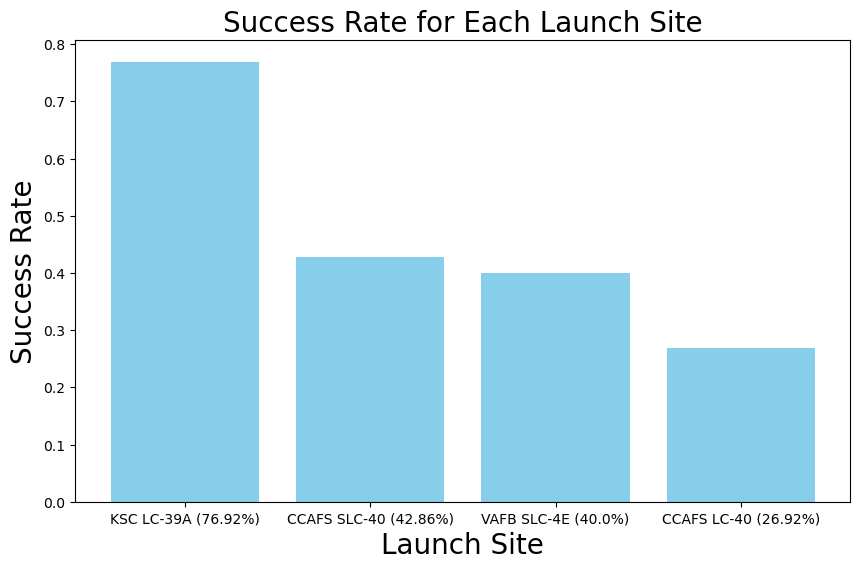

In [123]:
sites = data['Launch Site'].unique().tolist()
success_rate = {}
for site in sites:
    data_site = data[data['Launch Site'] == site]
    success_rate[site] = round(data_site[data_site['Class'] == 1].shape[0] / data_site.shape[0],4)
sorted_success_rates = sorted(success_rate.items(),key=lambda x: x[1],reverse=True)
site_names = [item[0] for item in sorted_success_rates]
success_rates = [item[1] for item in sorted_success_rates]

plt.figure(figsize=(10,6))
plt.bar(site_names, success_rates, color='skyblue')
plt.xticks(ticks=np.arange(len(site_names)),labels=[f'{site} ({round(rate*100,2)}%)' for site, rate in zip(site_names, success_rates)])
plt.xlabel("Launch Site",fontsize=20)
plt.ylabel("Success Rate",fontsize=20)
plt.title("Success Rate for Each Launch Site",fontsize=20)
plt.show()

### answer 3 & 4

In [ ]:
payload_range = [int(data['Payload Mass (kg)'].min()),int(data['Payload Mass (kg)'].max() if data['Payload Mass (kg)'].max() % 1000 == 0 else ((data['Payload Mass (kg)'].max() + 1000)-data['Payload Mass (kg)'].max()%1000))]
choice_interval = np.linspace(payload_range[0],payload_range[1],11,dtype=int)
all_choices = list(combinations(choice_interval,2))
all_choices.sort()

success_rate = {}
for choice in all_choices:
    aimed_df = data[(data['Payload Mass (kg)'] >= choice[0]) & (data['Payload Mass (kg)'] <= choice[1])]
    success_rate[choice] = round((aimed_df['Class'].sum() / aimed_df.shape[0])*100,2)
best_choice = sorted(success_rate.items(),key=lambda x:x[1],reverse=True)[0]

worst_choice = [choice for choice,rate in success_rate.items() if rate == 0]
print(f'the best choice is {best_choice[0]}, which is {best_choice[1]}%')
print(f'the worst choice is {worst_choice}, which is {min(success_rate.values())}%')


the best choice is (np.int64(3000), np.int64(4000)), which is 72.73%
the worst choice is [(np.int64(6000), np.int64(7000)), (np.int64(6000), np.int64(8000)), (np.int64(6000), np.int64(9000))], which is 0.0%


### answer 5

In [138]:
all_booster_version = data['Booster Version Category'].unique()
all_success_rate = {}
for booster in all_booster_version:
    booster_version_df = data[data['Booster Version Category'] == booster]
    success_rate = round(booster_version_df['Class'].sum() / len(booster_version_df),4)*100
    all_success_rate[booster] = success_rate

best_booster = max(all_success_rate.values())
best_booster_version = [booster for booster, rate in all_success_rate.items() if rate == best_booster]
print(f'the best booster version is {best_booster_version} with success rate {best_booster}%')



the best booster version is ['B5'] with success rate 100.0%
